<a href="https://colab.research.google.com/github/ariadna-guzman/E3-Deteccion-de-plagio-TC3002B.301/blob/main/Evidencia_1_An%C3%A1lisis_de_Similitud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evidencia 1: Análisis de Similitud

- Ariadna Jocelyn Guzmán Jiménez A01749373
- Jorge Chávez Badillo A01749448
- Amy Murakami Tsutsumi A01750185


## Importación de Librerías

In [26]:
# Kit de herramientas de lenguaje natural
import nltk 
from nltk.stem import PorterStemmer
from nltk.util import ngrams
# Para el cálculo de la distancia entre párrafos
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise
# Para la manipulación y lectura de archivos
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

## Importación de Textos

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
genuinos = '/content/drive/Shareddrives/Desarrollo de Aplicaciones Avanzadas de Ciencias Computacionales/Reto/Evidencia 1/2023-Datasets/Etapa1/documentos-genuinos/'
sospechosos = '/content/drive/Shareddrives/Desarrollo de Aplicaciones Avanzadas de Ciencias Computacionales/Reto/Evidencia 1/2023-Datasets/Etapa1/docmentos-sospechosos/'

*Sorted file names*

In [29]:
name_gen = sorted(os.listdir(genuinos))
name_sos = sorted(os.listdir(sospechosos))

## Funciones para el Análisis de Similitud 

### Stemming

In [30]:
# Función para aplicar la herramienta de stemming a los párrafos
def stemm_parrafo(parrafo):
  stemmer = PorterStemmer()
  parrafo = parrafo.split()
  parrafo_stemm = []

  for palabra in parrafo:
    palabra_stem = stemmer.stem(palabra)
    parrafo_stemm.append(palabra_stem)

  parrafo_str = ' '.join(parrafo_stemm)
  return parrafo_str

### Cálculo de la Distancia entre los Párrafos

In [31]:
# Función para vectrorizar
def vectorizar(ngram1, ngram2, n):
  lista_ngram = [' '.join(ngram1), ' '.join(ngram2)]
  vectorizador = CountVectorizer(ngram_range=(n, n))
  vectores_de_palabras = vectorizador.fit_transform(lista_ngram)
  vectores_de_palabras = vectores_de_palabras.toarray()
  return vectores_de_palabras

# Función para calcular las distancias entre párrafos
def distancia(parrafo1, parrafo2, n):
  parrafo = vectorizar(parrafo1, parrafo2, n)
  p1 = parrafo[0]
  p2 = parrafo[1]
  mat = [p1, p2]
  return pairwise.cosine_similarity(mat)

### N-gramas

In [32]:
# Función para crear ngramas
def crear_ngram(parrafo, n):
  ngram = ngrams(parrafo.split(), n)
  ngram_list = []
  for elem in ngram:
    ngram_list.append(' '.join(elem))
  #print(ngram_list)
  return ngram_list

### Métricas

In [33]:
# Función para obtener las métricas del modelo
def metricas(cf_mat):
  precision = cf_mat[0][0] / (cf_mat[0][0] + cf_mat[0][1])
  recall = cf_mat[0][0] / (cf_mat[0][0] + cf_mat[1][0])
  specificity = cf_mat[1][1] / (cf_mat[1][1] + cf_mat[0][1])
  print('Precision: {:.4f}'.format(precision))
  print('Recall: {:.4f}'.format(recall))
  print('Specificity: {:.4f}'.format(specificity))

### AUC-ROC Curve

In [34]:
# Función para gráficar la AUC-ROC
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

### Detección de Plagio

#### Código Fuente

In [35]:
files = []
distance = []

# Función para detectar el plagio usando la similitud de coseno
def plag_detection(sos_text):
   with open(sospechosos + sos_text, 'r') as file:
      datasos = file.read().rstrip()
      datasos_str = stemm_parrafo(datasos)
      unisos = crear_ngram(datasos_str, 1)
   for pathgen in os.listdir(genuinos):
      with open(genuinos + pathgen, 'r') as file:
        datagen = file.read().rstrip()
        datagen_str = stemm_parrafo(datagen)
        unigen = crear_ngram(datagen_str, 1)
      files.append(pathgen + ' ' + sos_text)
      distance.append(distancia(unigen, unisos, 1)[0][1])
   bothfiles = files[distance.index(max(distance))]
   bothfiles = bothfiles.split(' ')
   genfile = bothfiles[0]
   sosfile = bothfiles[1]
   if max(distance) > 0.7: #target
    print("El archivo {} tiene alta similitud con el archivo genuino {}. Similitud: {}".format(sosfile, genfile, max(distance)))

plag_detection('FID-01.txt')

El archivo FID-01.txt tiene alta similitud con el archivo genuino org-325.txt. Similitud: 0.9651821742843321


In [36]:
true_labels = []

for i in name_sos:
  if int(i[4:6]) % 2 == 0:
    true_labels.append(1)
  else:
    true_labels.append(0) 
# Función para detectar el plagio usando la similitud de coseno para todos los archivos sospechosos
def all_plag_detection(n):
  pred_labels = []
  files = []
  distance = []
  for pathsos in name_sos:
    with open(sospechosos + pathsos, 'r') as file:
      datasos = file.read().rstrip()
      datasos_str = stemm_parrafo(datasos)
      unisos = crear_ngram(datasos_str, n)

    for pathgen in name_gen:
      with open(genuinos + pathgen, 'r') as file:
        datagen = file.read().rstrip()
        datagen_str = stemm_parrafo(datagen)
        unigen = crear_ngram(datagen_str, n)
      distance.append(distancia(unigen, unisos, n)[0][1])
      if max(distance) > 0.7: # Target
        files.append('P' + ' ' + pathgen + ' ' + pathsos)
      else:
        files.append('NP' + ' ' + pathgen + ' ' + pathsos)
    bothfiles = files[distance.index(max(distance))]
    bothfiles = bothfiles.split(' ')
    label = bothfiles[0]
    genfile = bothfiles[1]
    sosfile = bothfiles[2]
    #print(files)
    if max(distance) > 0.7: # Target
      pred_labels.append(0)
      print("El archivo {} tiene alta similitud con el archivo genuino {}, Similitud: {:.4f}, Status: {}".format(sosfile, genfile, max(distance), '0'))
    else: 
      pred_labels.append(1)
      print("El archivo {} tiene baja similitud con el archivo genuino {}, Similitud: {:.4f}, Status: {}".format(sosfile, genfile, max(distance), '1'))

    files = []
    distance = []
  print("Prediction:\n", pred_labels)
  return pred_labels

## Interpretación a Considerar

* Valor de 1: Si la distancia de coseno es igual a 1, significa que los dos vectores son idénticos y están en la misma dirección. Esto indica una similitud máxima entre los vectores, ya que el ángulo entre ellos es cero grados.

* Valores cercanos a 1: Cuando la distancia de coseno se acerca a 1, indica una alta similitud entre los vectores. A medida que el valor se acerca a 1, el ángulo entre los vectores se acerca a cero grados y la similitud aumenta.

* Valor de 0: Si la distancia de coseno es igual a 0, significa que los vectores son ortogonales entre sí, es decir, están en ángulo recto. Esto indica que no hay similitud entre los vectores.

* Valores cercanos a 0: A medida que la distancia de coseno se acerca a 0, indica que los vectores tienen una similitud menor. Cuanto más cercano a cero sea el valor, mayor será el ángulo entre los vectores y menor será la similitud.

* Valor de -1: Si la distancia de coseno es igual a -1, significa que los vectores son opuestos entre sí. Están en direcciones completamente opuestas, lo que indica una similitud negativa máxima.

## Análisis de Similitud Usando Unigramas

### Pruebas Unitarias

In [37]:
pred_unigrama = all_plag_detection(1)
print("True:\n", true_labels)

El archivo FID-01.txt tiene alta similitud con el archivo genuino org-325.txt, Similitud: 0.9652, Status: 0
El archivo FID-02.txt tiene alta similitud con el archivo genuino org-325.txt, Similitud: 0.7566, Status: 0
El archivo FID-03.txt tiene baja similitud con el archivo genuino org-339.txt, Similitud: 0.6794, Status: 1
El archivo FID-04.txt tiene baja similitud con el archivo genuino org-413.txt, Similitud: 0.6304, Status: 1
El archivo FID-05.txt tiene alta similitud con el archivo genuino org-340.txt, Similitud: 0.8555, Status: 0
El archivo FID-06.txt tiene baja similitud con el archivo genuino org-413.txt, Similitud: 0.6681, Status: 1
El archivo FID-07.txt tiene alta similitud con el archivo genuino org-356.txt, Similitud: 0.8366, Status: 0
El archivo FID-08.txt tiene baja similitud con el archivo genuino org-331.txt, Similitud: 0.5089, Status: 1
El archivo FID-09.txt tiene alta similitud con el archivo genuino org-388.txt, Similitud: 0.7767, Status: 0
El archivo FID-10.txt tiene 

### Métricas del Modelo

In [38]:
print('Accuracy Acore: {:.4f}'.format(accuracy_score(true_labels, pred_unigrama)))
cf_mat = confusion_matrix(true_labels, pred_unigrama)
print('Confusion Matrix')
print(cf_mat)

Accuracy Acore: 0.8000
Confusion Matrix
[[7 1]
 [2 5]]


In [39]:
metricas(cf_mat)

Precision: 0.8750
Recall: 0.7778
Specificity: 0.8333


### AUC-ROC Curve

AUC score: 0.7946


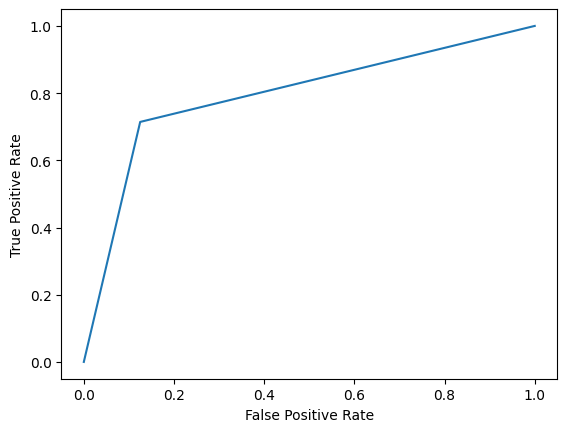

In [40]:
plot_roc_curve(true_labels, pred_unigrama)
print('AUC score: {:.4f}'.format(roc_auc_score(true_labels, pred_unigrama)))

## Análisis de Similitud Usando Bigramas

### Pruebas Unitarias

In [41]:
pred_bigrama = all_plag_detection(2)
print("True:\n", true_labels)

El archivo FID-01.txt tiene alta similitud con el archivo genuino org-325.txt, Similitud: 0.9196, Status: 0
El archivo FID-02.txt tiene baja similitud con el archivo genuino org-413.txt, Similitud: 0.6108, Status: 1
El archivo FID-03.txt tiene baja similitud con el archivo genuino org-339.txt, Similitud: 0.5263, Status: 1
El archivo FID-04.txt tiene baja similitud con el archivo genuino org-413.txt, Similitud: 0.4838, Status: 1
El archivo FID-05.txt tiene alta similitud con el archivo genuino org-340.txt, Similitud: 0.7788, Status: 0
El archivo FID-06.txt tiene baja similitud con el archivo genuino org-413.txt, Similitud: 0.4767, Status: 1
El archivo FID-07.txt tiene alta similitud con el archivo genuino org-356.txt, Similitud: 0.7374, Status: 0
El archivo FID-08.txt tiene baja similitud con el archivo genuino org-331.txt, Similitud: 0.3285, Status: 1
El archivo FID-09.txt tiene baja similitud con el archivo genuino org-388.txt, Similitud: 0.6186, Status: 1
El archivo FID-10.txt tiene 

### Métricas del Modelo

In [42]:
print('Accuracy Acore: {:.4f}'.format(accuracy_score(true_labels, pred_bigrama)))
cf_mat = confusion_matrix(true_labels, pred_bigrama)
print('Confusion Matrix')
print(cf_mat)

Accuracy Acore: 0.8667
Confusion Matrix
[[6 2]
 [0 7]]


In [43]:
metricas(cf_mat)

Precision: 0.7500
Recall: 1.0000
Specificity: 0.7778


### AUC-ROC Curve

AUC score: 0.8750


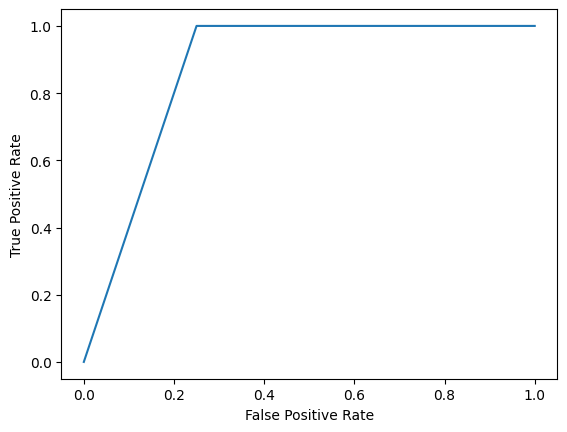

In [44]:
plot_roc_curve(true_labels, pred_bigrama)
print('AUC score: {:.4f}'.format(roc_auc_score(true_labels, pred_bigrama)))